In [1]:
import torch
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import time
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

from srgan import Generator, Discriminator, GeneratorLoss

import sys
sys.path.append('../')
from custom_image_dataset import CustomImageDataset
from image_helper import ImageHelper
from model_runner import ModelRunner

import image_patches

from SRCNN import SRCNN
sys.path.append('../DBPN/')
from DBPN_copied import DBPN


In [2]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

In [4]:
TRAIN_DATASET_NAME = "../datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "../datasets/VALIDATION_Flickr2K_DIV2K/"
# TRAIN_DATASET_NAME = "../datasets/set14/"
# VALIDATION_DATASET_NAME = "../datasets/Set5/"
PATCH_SIZE = 128 # 32 * 4

# PATCHES_PER_IMAGE_TRAIN = 30 #####
PATCHES_PER_IMAGE_TRAIN = 10
# PATCHES_PER_IMAGE_VALIDATION = 20 #####
PATCHES_PER_IMAGE_VALIDATION = 3 
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=10
VALIDATION_DATA_PATH = ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=3


In [5]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [6]:
%%time

SCALE_FACTOR=4

transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    # AddGaussianNoise(0., 0.1),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=10


100%|██████████| 2920/2920 [00:32<00:00, 89.31it/s] 


Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=10
Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=3


100%|██████████| 630/630 [00:02<00:00, 295.70it/s]


Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=3
Training set has 29179 instances
Validation set has 1888 instances
CPU times: user 26min 59s, sys: 5.26 s, total: 27min 4s
Wall time: 37.6 s


In [7]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1*(2**7))

num_workers = 0

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers)

CPU times: user 456 ms, sys: 140 ms, total: 597 ms
Wall time: 596 ms


In [8]:
netG = Generator(UPSCALE_FACTOR).to(device)
netD = Discriminator().to(device)
generator_criterion = GeneratorLoss().to(device)

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [10]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

d_loss_array = []
g_loss_array = []
d_score_array = []
g_score_array = []


In [11]:
N_EPOCHS = 150 # 150 is good enough for our model. gives decent enough results


In [12]:
model_runner = ModelRunner()

# Lists to store training and validation losses
train_losses = []
val_losses = []
discriminator_losses = []
time_array = []
epoch_array = []
lr_array = []

# Initialize tqdm progress bar for the entire training process
for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    epoch_array.append(epoch)
    lr_array.append(optimizerG.param_groups[0]['lr'])

    start_time = time.time()


    running_results = {'batch_sizes': 0, 'd_loss': 0,
                    "g_loss": 0, "d_score": 0, "g_score": 0}

    netG.train()
    netD.train()
    for data, target in train_dataloader:
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        # Move real images and noise vectors to the device
        real_img = Variable(target)
        real_img = real_img.to(device)
        z = Variable(data)
        z = z.to(device)

        ## Update Discriminator ##
        # Generate fake images using the generator
        fake_img = netG(z)
        # Zero out the gradients of the discriminator
        netD.zero_grad()

        # Compute the discriminator scores for real and fake images
        real_out = netD(real_img).mean()        
        fake_out = netD(fake_img).mean()

        # Calculate the discriminator loss
        d_loss = 1 - real_out + fake_out

        # Backpropagate the discriminator loss and update its parameters
        d_loss.backward(retain_graph = True)
        optimizerD.step()

        ## Now update Generator ##
        # Generate fake images again using the updated generator
        fake_img = netG(z)
        # Compute the discriminator score for the generated fake images
        fake_out = netD(fake_img).mean()

        # Zero out the gradients of the generator
        netG.zero_grad()

        # Calculate the generator loss using a predefined criterion
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        
        # Backpropagate the generator loss and update its parameters
        g_loss.backward()
        optimizerG.step()


        # Update the running results with batch-wise metrics
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size # TODO: check if this is correct (fake_out.item() * batch_size maybe?)


        ##### my code #####
        g_loss_array.append(g_loss.item())
        d_loss_array.append(d_loss.item())
        d_score_array.append(real_out.item())
        g_score_array.append(fake_out.item())
        ###################

    # Validation loop
    netG.eval()
    netD.eval()
    val_loss = 0

    # Iterate through each batch in the validation dataloader
    with torch.no_grad():
        for val_data, val_target in validation_dataloader:
            val_batch_size = val_data.size(0)
            real_img_val = Variable(val_target).to(device)
            z_val = Variable(val_data).to(device)

            fake_img_val = netG(z_val)
            fake_out_val = netD(fake_img_val).mean()

            # Calculate validation loss
            val_loss += generator_criterion(fake_out_val, fake_img_val, real_img_val).item()
        
        # Calculate average validation loss
        avg_val_loss = val_loss
        val_losses.append(avg_val_loss)

    end_time = time.time() - start_time
    time_array.append(end_time)

    # Update the tqdm progress bar to show relevant information
    tqdm.write(
        "[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f Val Loss: %.4f Time: %.4f"
        % (
            epoch + 1, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes'],
            avg_val_loss,
            end_time
        ))
    
    # Store training loss for plotting
    train_losses.append(running_results['g_loss'] / running_results['batch_sizes'])

    discriminator_losses.append(running_results['d_loss'] / running_results['batch_sizes'])




Epochs:   0%|          | 0/150 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epochs:   1%|          | 1/150 [01:46<4:23:51, 106.25s/it]

[1/150] Loss_D: 0.1730 Loss_G: 0.0108 D(x): 0.9112 D(G(z)): 0.0666 Val Loss: 0.1013 Time: 106.2469


Epochs:   1%|▏         | 2/150 [03:32<4:22:03, 106.24s/it]

[2/150] Loss_D: 0.0636 Loss_G: 0.0069 D(x): 0.9731 D(G(z)): 0.0308 Val Loss: 0.0947 Time: 106.2299


Epochs:   2%|▏         | 3/150 [05:18<4:20:11, 106.20s/it]

[3/150] Loss_D: 0.0007 Loss_G: 0.0065 D(x): 0.9996 D(G(z)): 0.0004 Val Loss: 0.0927 Time: 106.1556


Epochs:   3%|▎         | 4/150 [07:04<4:18:13, 106.12s/it]

[4/150] Loss_D: 0.0003 Loss_G: 0.0064 D(x): 0.9999 D(G(z)): 0.0001 Val Loss: 0.0925 Time: 105.9829


Epochs:   3%|▎         | 5/150 [08:50<4:16:19, 106.06s/it]

[5/150] Loss_D: 0.0002 Loss_G: 0.0062 D(x): 0.9999 D(G(z)): 0.0001 Val Loss: 0.0855 Time: 105.9629


Epochs:   4%|▍         | 6/150 [10:36<4:14:19, 105.97s/it]

[6/150] Loss_D: 0.0001 Loss_G: 0.0060 D(x): 0.9999 D(G(z)): 0.0001 Val Loss: 0.0898 Time: 105.7860


Epochs:   5%|▍         | 7/150 [12:22<4:12:46, 106.06s/it]

[7/150] Loss_D: 0.0001 Loss_G: 0.0060 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0852 Time: 106.2333


Epochs:   5%|▌         | 8/150 [14:08<4:11:11, 106.14s/it]

[8/150] Loss_D: 0.0001 Loss_G: 0.0059 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0852 Time: 106.3006


Epochs:   6%|▌         | 9/150 [15:55<4:09:30, 106.18s/it]

[9/150] Loss_D: 0.0000 Loss_G: 0.0058 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0819 Time: 106.2589


Epochs:   7%|▋         | 10/150 [17:41<4:07:44, 106.18s/it]

[10/150] Loss_D: 0.0000 Loss_G: 0.0058 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0861 Time: 106.1742


Epochs:   7%|▋         | 11/150 [19:27<4:06:04, 106.22s/it]

[11/150] Loss_D: 0.0000 Loss_G: 0.0057 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0836 Time: 106.3095


Epochs:   8%|▊         | 12/150 [21:13<4:04:12, 106.18s/it]

[12/150] Loss_D: 0.0776 Loss_G: 0.0057 D(x): 0.9483 D(G(z)): 0.0230 Val Loss: 0.0786 Time: 106.0764


Epochs:   9%|▊         | 13/150 [22:59<4:02:21, 106.14s/it]

[13/150] Loss_D: 0.0002 Loss_G: 0.0056 D(x): 0.9999 D(G(z)): 0.0001 Val Loss: 0.0848 Time: 106.0717


Epochs:   9%|▉         | 14/150 [24:45<4:00:27, 106.09s/it]

[14/150] Loss_D: 0.0001 Loss_G: 0.0055 D(x): 0.9999 D(G(z)): 0.0001 Val Loss: 0.0868 Time: 105.9516


Epochs:  10%|█         | 15/150 [26:31<3:58:42, 106.09s/it]

[15/150] Loss_D: 0.0001 Loss_G: 0.0055 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0772 Time: 106.0993


Epochs:  11%|█         | 16/150 [28:18<3:57:02, 106.14s/it]

[16/150] Loss_D: 0.0001 Loss_G: 0.0055 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0826 Time: 106.2383


Epochs:  11%|█▏        | 17/150 [30:04<3:55:19, 106.16s/it]

[17/150] Loss_D: 0.0000 Loss_G: 0.0054 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0773 Time: 106.2222


Epochs:  12%|█▏        | 18/150 [31:50<3:53:30, 106.14s/it]

[18/150] Loss_D: 0.0000 Loss_G: 0.0055 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0767 Time: 106.0814


Epochs:  13%|█▎        | 19/150 [33:36<3:51:40, 106.11s/it]

[19/150] Loss_D: 0.0000 Loss_G: 0.0054 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0780 Time: 106.0388


Epochs:  13%|█▎        | 20/150 [35:22<3:49:55, 106.12s/it]

[20/150] Loss_D: 0.0000 Loss_G: 0.0054 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0766 Time: 106.1267


Epochs:  14%|█▍        | 21/150 [37:08<3:48:14, 106.16s/it]

[21/150] Loss_D: 0.0000 Loss_G: 0.0053 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0767 Time: 106.2467


Epochs:  15%|█▍        | 22/150 [38:55<3:46:30, 106.17s/it]

[22/150] Loss_D: 0.0000 Loss_G: 0.0053 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0788 Time: 106.2068


Epochs:  15%|█▌        | 23/150 [40:40<3:44:33, 106.09s/it]

[23/150] Loss_D: 0.0000 Loss_G: 0.0053 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0778 Time: 105.9071


Epochs:  16%|█▌        | 24/150 [42:26<3:42:38, 106.02s/it]

[24/150] Loss_D: 0.0000 Loss_G: 0.0053 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0758 Time: 105.8437


Epochs:  17%|█▋        | 25/150 [44:12<3:40:44, 105.96s/it]

[25/150] Loss_D: 0.0000 Loss_G: 0.0053 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0762 Time: 105.8046


Epochs:  17%|█▋        | 26/150 [45:58<3:38:57, 105.95s/it]

[26/150] Loss_D: 0.0000 Loss_G: 0.0052 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0774 Time: 105.9198


Epochs:  18%|█▊        | 27/150 [47:44<3:37:07, 105.92s/it]

[27/150] Loss_D: 0.0000 Loss_G: 0.0052 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0806 Time: 105.8414


Epochs:  19%|█▊        | 28/150 [49:30<3:35:21, 105.91s/it]

[28/150] Loss_D: 0.0000 Loss_G: 0.0052 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0772 Time: 105.8997


Epochs:  19%|█▉        | 29/150 [51:16<3:33:30, 105.87s/it]

[29/150] Loss_D: 0.0000 Loss_G: 0.0052 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0758 Time: 105.7813


Epochs:  20%|██        | 30/150 [53:01<3:31:41, 105.85s/it]

[30/150] Loss_D: 0.0000 Loss_G: 0.0052 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0741 Time: 105.7815


Epochs:  21%|██        | 31/150 [54:47<3:29:55, 105.84s/it]

[31/150] Loss_D: 0.0000 Loss_G: 0.0052 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0749 Time: 105.8283


Epochs:  21%|██▏       | 32/150 [56:33<3:28:06, 105.82s/it]

[32/150] Loss_D: 0.0000 Loss_G: 0.0051 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0744 Time: 105.7500


Epochs:  22%|██▏       | 33/150 [58:19<3:26:18, 105.80s/it]

[33/150] Loss_D: 0.0000 Loss_G: 0.0051 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0756 Time: 105.7721


Epochs:  23%|██▎       | 34/150 [1:00:04<3:24:29, 105.77s/it]

[34/150] Loss_D: 0.0000 Loss_G: 0.0052 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0748 Time: 105.6977


Epochs:  23%|██▎       | 35/150 [1:01:50<3:22:44, 105.78s/it]

[35/150] Loss_D: 0.0000 Loss_G: 0.0051 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0744 Time: 105.7923


Epochs:  24%|██▍       | 36/150 [1:03:36<3:20:58, 105.78s/it]

[36/150] Loss_D: 0.0000 Loss_G: 0.0051 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0744 Time: 105.7635


Epochs:  25%|██▍       | 37/150 [1:05:22<3:19:13, 105.78s/it]

[37/150] Loss_D: 0.0000 Loss_G: 0.0051 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0745 Time: 105.7857


Epochs:  25%|██▌       | 38/150 [1:07:08<3:17:27, 105.78s/it]

[38/150] Loss_D: 0.0000 Loss_G: 0.0051 D(x): 1.0000 D(G(z)): 0.0000 Val Loss: 0.0744 Time: 105.7911


Epochs:  26%|██▌       | 39/150 [1:08:53<3:15:41, 105.78s/it]

[39/150] Loss_D: 0.1801 Loss_G: 0.0050 D(x): 0.8849 D(G(z)): 0.0652 Val Loss: 0.0721 Time: 105.7706


Epochs:  27%|██▋       | 40/150 [1:10:39<3:13:53, 105.76s/it]

[40/150] Loss_D: 1.0052 Loss_G: 0.0048 D(x): 0.2695 D(G(z)): 0.2742 Val Loss: 0.0715 Time: 105.7133


Epochs:  27%|██▋       | 41/150 [1:12:25<3:11:58, 105.68s/it]

[41/150] Loss_D: 1.0025 Loss_G: 0.0049 D(x): 0.2525 D(G(z)): 0.2540 Val Loss: 0.0730 Time: 105.4717


Epochs:  28%|██▊       | 42/150 [1:14:10<3:10:11, 105.66s/it]

[42/150] Loss_D: 1.0047 Loss_G: 0.0048 D(x): 0.2715 D(G(z)): 0.2749 Val Loss: 0.0721 Time: 105.6193


Epochs:  29%|██▊       | 43/150 [1:15:56<3:08:26, 105.67s/it]

[43/150] Loss_D: 1.0038 Loss_G: 0.0049 D(x): 0.1959 D(G(z)): 0.1990 Val Loss: 0.0718 Time: 105.7009


Epochs:  29%|██▉       | 44/150 [1:17:42<3:06:40, 105.66s/it]

[44/150] Loss_D: 1.0033 Loss_G: 0.0048 D(x): 0.2801 D(G(z)): 0.2827 Val Loss: 0.0711 Time: 105.6402


Epochs:  30%|███       | 45/150 [1:19:27<3:04:52, 105.64s/it]

[45/150] Loss_D: 1.0018 Loss_G: 0.0048 D(x): 0.2712 D(G(z)): 0.2725 Val Loss: 0.0699 Time: 105.5808


Epochs:  31%|███       | 46/150 [1:21:13<3:03:05, 105.63s/it]

[46/150] Loss_D: 1.0003 Loss_G: 0.0047 D(x): 0.3273 D(G(z)): 0.3274 Val Loss: 0.0705 Time: 105.6092


Epochs:  31%|███▏      | 47/150 [1:22:58<3:01:20, 105.64s/it]

[47/150] Loss_D: 0.9974 Loss_G: 0.0047 D(x): 0.3410 D(G(z)): 0.3372 Val Loss: 0.0691 Time: 105.6580


Epochs:  32%|███▏      | 48/150 [1:24:44<2:59:27, 105.56s/it]

[48/150] Loss_D: 0.9928 Loss_G: 0.0047 D(x): 0.3729 D(G(z)): 0.3652 Val Loss: 0.0686 Time: 105.3872


Epochs:  33%|███▎      | 49/150 [1:26:29<2:57:41, 105.56s/it]

[49/150] Loss_D: 0.9899 Loss_G: 0.0045 D(x): 0.5261 D(G(z)): 0.5156 Val Loss: 0.0661 Time: 105.5477


Epochs:  33%|███▎      | 50/150 [1:28:15<2:56:00, 105.60s/it]

[50/150] Loss_D: 0.9827 Loss_G: 0.0044 D(x): 0.6072 D(G(z)): 0.5885 Val Loss: 0.0673 Time: 105.6917


Epochs:  34%|███▍      | 51/150 [1:30:00<2:54:11, 105.57s/it]

[51/150] Loss_D: 0.9441 Loss_G: 0.0047 D(x): 0.3957 D(G(z)): 0.3366 Val Loss: 0.0708 Time: 105.4847


Epochs:  35%|███▍      | 52/150 [1:31:46<2:52:23, 105.55s/it]

[52/150] Loss_D: 0.9039 Loss_G: 0.0047 D(x): 0.4604 D(G(z)): 0.3604 Val Loss: 0.0728 Time: 105.5042


Epochs:  35%|███▌      | 53/150 [1:33:32<2:50:45, 105.62s/it]

[53/150] Loss_D: 0.7474 Loss_G: 0.0048 D(x): 0.6014 D(G(z)): 0.3327 Val Loss: 0.0728 Time: 105.7815


Epochs:  36%|███▌      | 54/150 [1:35:18<2:49:04, 105.67s/it]

[54/150] Loss_D: 0.6627 Loss_G: 0.0045 D(x): 0.8711 D(G(z)): 0.5171 Val Loss: 0.0724 Time: 105.7744


Epochs:  37%|███▋      | 55/150 [1:37:02<2:46:47, 105.35s/it]

[55/150] Loss_D: 0.9484 Loss_G: 0.0041 D(x): 0.9770 D(G(z)): 0.9193 Val Loss: 0.0586 Time: 104.5982


Epochs:  37%|███▋      | 56/150 [1:38:45<2:43:59, 104.68s/it]

[56/150] Loss_D: 1.0000 Loss_G: 0.0040 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0604 Time: 103.1119


Epochs:  38%|███▊      | 57/150 [1:40:28<2:41:33, 104.24s/it]

[57/150] Loss_D: 1.0000 Loss_G: 0.0039 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0592 Time: 103.2045


Epochs:  39%|███▊      | 58/150 [1:42:12<2:39:22, 103.94s/it]

[58/150] Loss_D: 1.0000 Loss_G: 0.0040 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0587 Time: 103.2601


Epochs:  39%|███▉      | 59/150 [1:43:55<2:37:21, 103.75s/it]

[59/150] Loss_D: 1.0000 Loss_G: 0.0039 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0586 Time: 103.2891


Epochs:  40%|████      | 60/150 [1:45:38<2:35:24, 103.61s/it]

[60/150] Loss_D: 1.0000 Loss_G: 0.0039 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0586 Time: 103.2776


Epochs:  41%|████      | 61/150 [1:47:21<2:33:27, 103.45s/it]

[61/150] Loss_D: 1.0000 Loss_G: 0.0039 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0589 Time: 103.0812


Epochs:  41%|████▏     | 62/150 [1:49:05<2:31:40, 103.41s/it]

[62/150] Loss_D: 1.0000 Loss_G: 0.0039 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0585 Time: 103.3230


Epochs:  42%|████▏     | 63/150 [1:50:48<2:29:52, 103.36s/it]

[63/150] Loss_D: 1.0000 Loss_G: 0.0039 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0591 Time: 103.2404


Epochs:  43%|████▎     | 64/150 [1:52:31<2:28:05, 103.32s/it]

[64/150] Loss_D: 1.0000 Loss_G: 0.0039 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0581 Time: 103.2080


Epochs:  43%|████▎     | 65/150 [1:54:14<2:26:12, 103.20s/it]

[65/150] Loss_D: 1.0000 Loss_G: 0.0039 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0592 Time: 102.9300


Epochs:  44%|████▍     | 66/150 [1:55:57<2:24:22, 103.13s/it]

[66/150] Loss_D: 1.0000 Loss_G: 0.0039 D(x): 1.0000 D(G(z)): 1.0000 Val Loss: 0.0587 Time: 102.9564


Epochs:  44%|████▍     | 66/150 [1:57:01<2:28:56, 106.39s/it]


KeyboardInterrupt: 

In [19]:
# epoch_array.pop()
# lr_array.pop()
print(len(epoch_array))
print(len(lr_array))
print(len(time_array))
print(len(train_losses))
print(len(val_losses))
print(len(discriminator_losses))

66
66
66
66
66
66


In [20]:
df = model_runner.create_model_df(epoch_array, time_array, lr_array, train_losses, val_losses,
                            extra_columns={"discriminator_losses": discriminator_losses}        
)
df

,epoch,time,lr,train_loss,validation_loss,discriminator_losses
0,0,106.246866,0.0002,0.010846,0.101313,0.172992
1,1,106.229900,0.0002,0.006914,0.094694,0.063609
2,2,106.155606,0.0002,0.006543,0.092745,0.000723
3,3,105.982876,0.0002,0.006407,0.092485,0.000260
4,4,105.962893,0.0002,0.006173,0.085464,0.000155
...,...,...,...,...,...,...
61,61,103.322960,0.0002,0.003919,0.058489,1.000000
62,62,103.240357,0.0002,0.003922,0.059091,1.000000
63,63,103.208000,0.0002,0.003941,0.058083,1.000000
64,64,102.930042,0.0002,0.003907,0.059213,1.000000


In [15]:
# We will just make sure that this model trains 5 epochs successfuly
# This will take around 2 hours to train, please monitor colab
# To make sure that it does not time out
# There might be few errors, mostly due to typos
# The progress bar acts slightly weird
# But you see the model is now training


should_upsample MUST ONLY BE `TRUE` for SRCNN


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


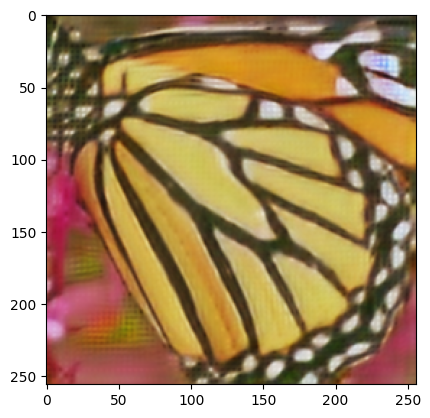

In [21]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=netG,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True,
    should_upsample=False
)

In [24]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "SRGAN", "model": netG,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:02, 48.67it/s]
100it [00:01, 68.44it/s]


,PSNR,SSIM
SRGAN,22.764347,0.647016
Bicubic,23.045410,0.632868


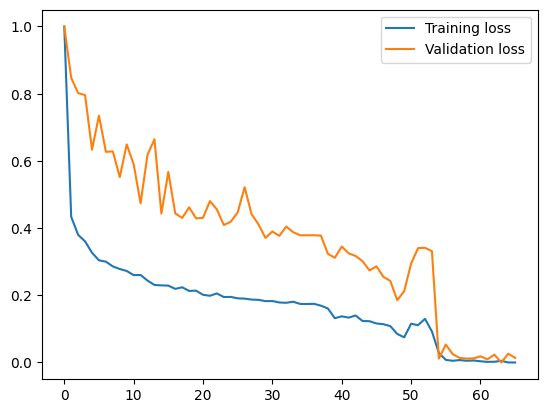

In [27]:
# plot the losses
import matplotlib.pyplot as plt
plt.plot(model_runner.normalize_data(train_losses), label='Training loss')
plt.plot(model_runner.normalize_data(val_losses), label='Validation loss')
plt.legend()
plt.show()


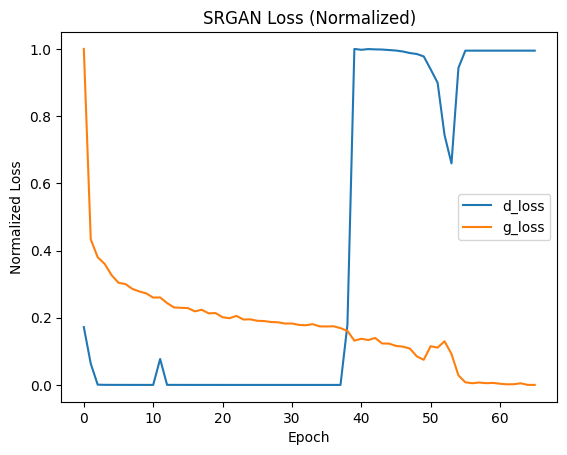

In [26]:
normalized_discriminator_losses = model_runner.normalize_data(discriminator_losses)
normalized_train_losses = model_runner.normalize_data(train_losses)

# Plot normalized data
plt.plot(normalized_discriminator_losses, label='d_loss')
plt.plot(normalized_train_losses, label='g_loss')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.title('SRGAN Loss (Normalized)')
plt.legend()
plt.show()


In [28]:
# model_runner.save_model_df("./../results/srgan/dataframes/srgan_netG_follwing_paper_df_66_epochs_graphs_are_working.csv", df_to_save=df)

In [29]:
# model_runner.save_model_weights(netG, '../results/srgan/trained_models/srgan_netG_follwing_paper_66_epochs_graphs_are_working.pth')
# model_runner.save_model_weights(netD, '../results/srgan/trained_models/srgan_netD_follwing_paper_66_epochs_graphs_are_working.pth')

In [30]:
netG_test = Generator(UPSCALE_FACTOR).to('cpu')
netG_test.load_state_dict(torch.load('../results/srgan/trained_models/srgan_netG_follwing_paper_66_epochs_graphs_are_working.pth',  map_location=torch.device('cpu')))


<All keys matched successfully>

should_upsample MUST ONLY BE `TRUE` for SRCNN


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


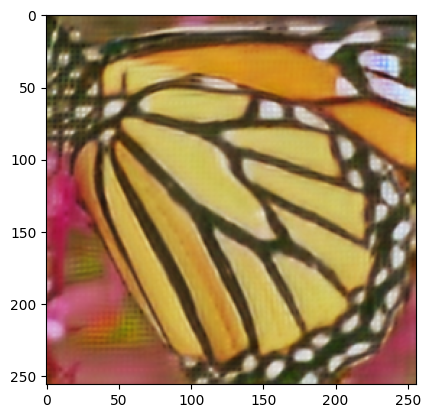

In [31]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=netG_test.to('cpu'),
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True,
    should_upsample=False,
    device='cpu'
)

In [32]:
model_runner = ModelRunner(device='cpu')
model_runner.compare_models(
    [
        {"name": "SRGAN", "model": netG_test,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:13,  7.18it/s]
100it [00:02, 45.73it/s]


,PSNR,SSIM
SRGAN,22.76432,0.647017
Bicubic,23.04541,0.632869


In [27]:
model_f2_5 = SRCNN(f2=5).to(device)
model_f2_5.load_state_dict(torch.load('../results/srcnn/trained_models/model_f2_5.pth', map_location=torch.device('cpu')))

model_without_noise = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_without_noise.load_state_dict(torch.load('./trained_models/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.pth', map_location=torch.device('cpu')))


FileNotFoundError: [Errno 2] No such file or directory: './trained_models/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.pth'

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the val

tensor.shape = torch.Size([3, 344, 228])
tensor.shape = torch.Size([1, 3, 86, 57])


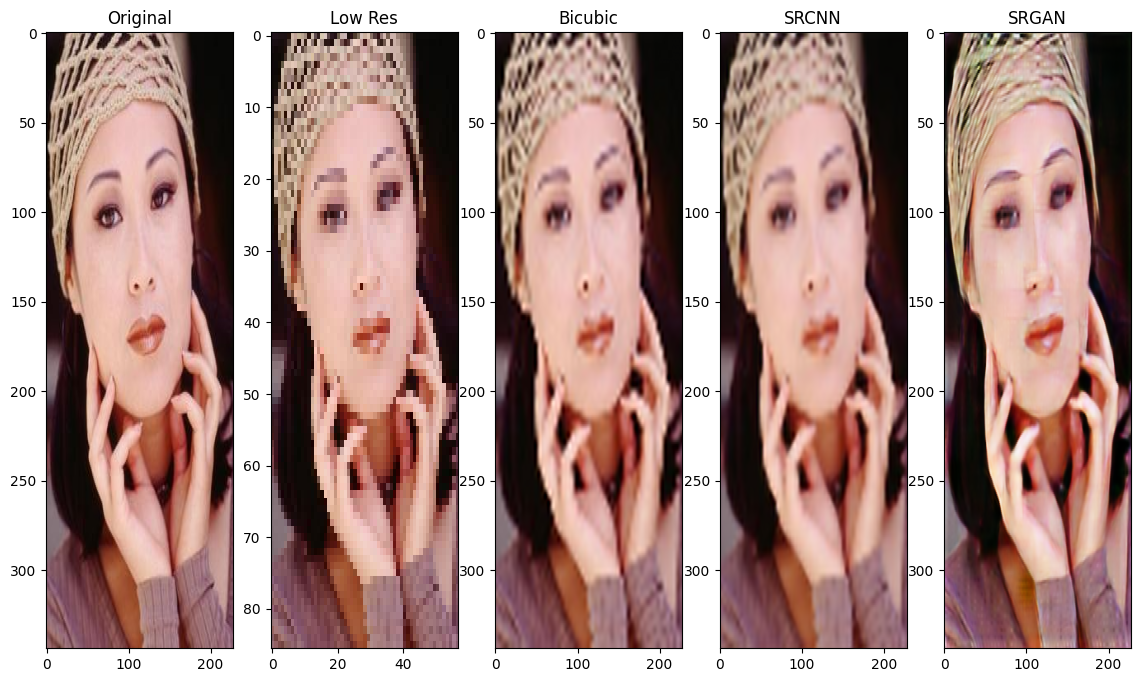

In [28]:
IMAGE_EXAMPLE = f"../datasets/Set5/woman.png"

image_helper.show_tensor_as_images_side_by_side(
    [
        {
            "label": "Original",
            "tensor": image_helper.image_to_tensor(IMAGE_EXAMPLE),
        },
        {
            "label": "Low Res",
            "tensor": image_helper.downsample_image_as_tensor(
                IMAGE_EXAMPLE, 4, interpolation=Image.BICUBIC,
            ),
        },
        {
            "label": "Bicubic",
            "tensor": image_helper.downsample_and_upsample_image_as_tensor(
                IMAGE_EXAMPLE, 4
            ),
        },
        {
            "label": "SRCNN",
            "tensor": image_helper.apply_model_to_image(
                model_f2_5,
                IMAGE_EXAMPLE,
                4
            )
        },
        {
            "label": "SRGAN",
            "tensor": image_helper.apply_model_to_image(
                netG_test.to('cpu'),
                IMAGE_EXAMPLE,
                downsample_factor=4,
                should_upsample=False,
                unsqueeze=True,
                device='cpu'
            )
        },
        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=test_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN v4 (triangular)",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=model_triangular,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN v5 (triangular2)",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=model_triangular2,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN v6 (triangular2)",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=model_triangular2,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=more_data_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=even_more_data_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
        # {
        #     "label": "DBPN *",
        #     "tensor": image_helper.apply_model_to_image(
        #         model=more_epochs_less_data_model,
        #         image=IMAGE_EXAMPLE,
        #         downsample_factor=4,
        #         should_upsample=False,
        #         unsqueeze=True
        #     )
        # },
    ],
)

In [30]:
model_runner.compare_models(
    [
        {
            "name": "SRCNN",
            "model": model_f2_5,
        },
        {"name": "DBPN without noise", "model": model_without_noise,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
        {"name": "SRGAN", "model": netG_test,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

100it [00:04, 24.49it/s]
100it [01:23,  1.19it/s]
100it [00:07, 13.97it/s]
100it [00:01, 70.65it/s]


,PSNR,SSIM
SRCNN,23.475697,0.630280
DBPN without noise,9.236373,0.055450
SRGAN,24.347925,0.667682
Bicubic,23.045410,0.632869
